## Data Prep

In [37]:
import scipy.io as sio
from slf_dataset import mean_slf
import torch
import torch
import torch.nn as nn
from helper import *

mean_slf = 0.0005

data = sio.loadmat('data/onebitdata')

L = 10
f = 0.5
std_probit = 0.008
# std_probits = [0.00001, 0.0001, 0.001, 0.005, 0.008, 0.01,]
std_probits = [0.0001]
nmse_list = []
cost_list = []
loss_model = 'probit'  # one of 'sigmoid', 'probit', and 'determ'
maxIter = 50
innerIter = 10
projection_interval = 5
l1 = 0.0
l2 = 0.01
for std_probit in std_probits:
    S = torch.from_numpy(data['S']).type(torch.float32)
    T = torch.from_numpy(data['T']).type(torch.float32)
    C = torch.from_numpy(data['C']).type(torch.float32)
    S_true = torch.from_numpy(data['S_true']).type(torch.float32)
    C_true = torch.from_numpy(data['C_true']).type(torch.float32)
    T_true = torch.from_numpy(data['T_true']).type(torch.float32)

    Om = torch.from_numpy(data['Om']).type(torch.float32)

    T = T.permute(2,0,1)
    T_true = T_true.permute(2,0,1)
    S = S.permute(2,0,1)
    S_true = S_true.permute(2,0,1)
    C = C.permute(1,0)
    C_true = C_true.permute(1,0)

    W = Om.unsqueeze(dim=0)
    W = W.unsqueeze(dim=0)
    Wx = W.repeat(64,1,1,1)

    T_old = T.clone()
    S_old = S.clone()


    R,I,J = S.shape
   

    if loss_model=='sigmoid':
        T = T_true-mean_slf
        T = dither_sigmoid(T)
    elif loss_model=='probit':
        T = T_true-mean_slf
        T = dither_probit(T, std_probit)
    elif loss_model =='determ':
        pass



    S = nn.Parameter(S.unsqueeze(dim=1).clone())
    C = nn.Parameter(C.clone())
    T_hat = get_tensor(S,C)

    ## Init optimizer
    optimizerC = torch.optim.Adam([C], lr=0.001)
    optimizerS = torch.optim.Adam([S], lr=0.001)

    criterion = NegLikelihood(mean=mean_slf, std=std_probit, probit=True if loss_model=='probit' else False)


    costs = []
    nmses = []
    # maxIter=0

    for i in range(maxIter):
#         # C optimization
#         optimizerC.zero_grad()
#         optimizerS.zero_grad()

#         T_hat = get_tensor(S,C)

#         cost = criterion(T_hat, T) + l1*torch.norm(S, 'fro') + l2*torch.norm(C, 'fro')
#         print("Cost: {} and NMSE: {}".format(cost.item(), NMSE(T_hat, T_true)))
#         cost.backward()
#         optimizerC.step()
#         optimizerS.step()
    
        # C optimization
        for j in range(innerIter):
            optimizerS.zero_grad()

            T_hat = get_tensor(S,C)

            cost = criterion(T_hat, T) + l1*torch.norm(S, 'fro') + l2*torch.norm(C, 'fro')
            print("S opt Cost: {} and NMSE: {}".format(cost.item(), NMSE(T_hat, T_true)))
            cost.backward()
            optimizerS.step()
        print()
        for j in range(innerIter):
            optimizerC.zero_grad()
            
            T_hat = get_tensor(S,C)

            cost = criterion(T_hat, T) + l1*torch.norm(S, 'fro') + l2*torch.norm(C, 'fro')
            print("C opt Cost: {} and NMSE: {}".format(cost.item(), NMSE(T_hat, T_true)))
            cost.backward()
            
            optimizerC.step()

        print()
        if i%projection_interval == 10:
            print('projection onto feasible set')
            with torch.no_grad():
                u, s, v = torch.svd(S)
                s[:,:,L:] = 0
                S.copy_(torch.matmul(torch.matmul(u, torch.diag_embed(s)), v.transpose(-2,-1)))
                C[C<0] = 0
        costs.append(cost.item())
        nmses.append(NMSE(T_hat, T_true))
    cost_list.append(costs)
    nmse_list.append(nmses)

S opt Cost: 0.3370470702648163 and NMSE: 0.4521910548210144
S opt Cost: 0.4579855501651764 and NMSE: 0.44788455963134766
S opt Cost: 0.18794691562652588 and NMSE: 0.4457082748413086
S opt Cost: 0.17492073774337769 and NMSE: 0.44548994302749634
S opt Cost: 0.3906124532222748 and NMSE: 0.4462714195251465
S opt Cost: 0.47017940878868103 and NMSE: 0.44694918394088745
S opt Cost: 0.48509836196899414 and NMSE: 0.44773951172828674
S opt Cost: 0.3958085775375366 and NMSE: 0.4487171173095703
S opt Cost: 0.4160134196281433 and NMSE: 0.45000171661376953
S opt Cost: 0.4590326249599457 and NMSE: 0.45149293541908264

C opt Cost: 0.44688162207603455 and NMSE: 0.45310714840888977
C opt Cost: 0.43724656105041504 and NMSE: 0.45151156187057495
C opt Cost: 0.43332380056381226 and NMSE: 0.4501152038574219
C opt Cost: 0.4290425479412079 and NMSE: 0.44883766770362854
C opt Cost: 0.4267251789569855 and NMSE: 0.44766637682914734
C opt Cost: 0.4250967800617218 and NMSE: 0.44656458497047424
C opt Cost: 0.4245305

C opt Cost: 0.3722738027572632 and NMSE: 0.40389493107795715

S opt Cost: 0.3722320795059204 and NMSE: 0.40380704402923584
S opt Cost: 0.37023231387138367 and NMSE: 0.40325674414634705
S opt Cost: 0.3749803900718689 and NMSE: 0.4026792347431183
S opt Cost: 0.36958906054496765 and NMSE: 0.4020939767360687
S opt Cost: 0.3687310516834259 and NMSE: 0.4015200138092041
S opt Cost: 0.367721289396286 and NMSE: 0.4009609520435333
S opt Cost: 0.36560097336769104 and NMSE: 0.40042436122894287
S opt Cost: 0.3639506995677948 and NMSE: 0.3999137878417969
S opt Cost: 0.36353641748428345 and NMSE: 0.3994283676147461
S opt Cost: 0.36375191807746887 and NMSE: 0.39896419644355774

C opt Cost: 0.3650590181350708 and NMSE: 0.3985140919685364
C opt Cost: 0.3649967610836029 and NMSE: 0.39835429191589355
C opt Cost: 0.3649287521839142 and NMSE: 0.3981473445892334
C opt Cost: 0.36385858058929443 and NMSE: 0.39790281653404236
C opt Cost: 0.36378195881843567 and NMSE: 0.3976805508136749
C opt Cost: 0.36371645331

C opt Cost: 0.36056268215179443 and NMSE: 0.37575191259384155
C opt Cost: 0.36055678129196167 and NMSE: 0.37575840950012207

S opt Cost: 0.3605508804321289 and NMSE: 0.3757643401622772
S opt Cost: 0.36209261417388916 and NMSE: 0.3756154477596283
S opt Cost: 0.36208009719848633 and NMSE: 0.37546294927597046
S opt Cost: 0.3606867790222168 and NMSE: 0.37530750036239624
S opt Cost: 0.36053112149238586 and NMSE: 0.37515830993652344
S opt Cost: 0.3605395257472992 and NMSE: 0.3750172555446625
S opt Cost: 0.3606497645378113 and NMSE: 0.37488633394241333
S opt Cost: 0.3608308732509613 and NMSE: 0.3747674226760864
S opt Cost: 0.36242595314979553 and NMSE: 0.3746612071990967
S opt Cost: 0.3629927635192871 and NMSE: 0.3745667636394501

C opt Cost: 0.36302894353866577 and NMSE: 0.37448248267173767
C opt Cost: 0.36302441358566284 and NMSE: 0.3744993209838867
C opt Cost: 0.3630217909812927 and NMSE: 0.3745274543762207
C opt Cost: 0.36302220821380615 and NMSE: 0.3745664656162262
C opt Cost: 0.36302602

C opt Cost: 0.3532496690750122 and NMSE: 0.37413308024406433
C opt Cost: 0.3532458543777466 and NMSE: 0.37413260340690613

S opt Cost: 0.3532419502735138 and NMSE: 0.3741317689418793
S opt Cost: 0.3532073497772217 and NMSE: 0.37416428327560425
S opt Cost: 0.3531743586063385 and NMSE: 0.374191015958786
S opt Cost: 0.3531436622142792 and NMSE: 0.374215692281723
S opt Cost: 0.3531128764152527 and NMSE: 0.37424302101135254
S opt Cost: 0.35308825969696045 and NMSE: 0.37427395582199097
S opt Cost: 0.3530591130256653 and NMSE: 0.374310702085495
S opt Cost: 0.3530312776565552 and NMSE: 0.37435299158096313
S opt Cost: 0.3530031442642212 and NMSE: 0.3744005560874939
S opt Cost: 0.3529759347438812 and NMSE: 0.3744523525238037

C opt Cost: 0.3529473543167114 and NMSE: 0.3745068907737732
C opt Cost: 0.3529432713985443 and NMSE: 0.37450841069221497
C opt Cost: 0.3529389500617981 and NMSE: 0.3745124638080597
C opt Cost: 0.35293471813201904 and NMSE: 0.3745189905166626
C opt Cost: 0.35293033719062805 

C opt Cost: 0.3533777594566345 and NMSE: 0.3800618350505829
C opt Cost: 0.3533714711666107 and NMSE: 0.38005515933036804
C opt Cost: 0.3533647656440735 and NMSE: 0.3800484240055084
C opt Cost: 0.35335779190063477 and NMSE: 0.3800415098667145
C opt Cost: 0.35335054993629456 and NMSE: 0.3800339996814728
C opt Cost: 0.3533429503440857 and NMSE: 0.38002604246139526

S opt Cost: 0.35333511233329773 and NMSE: 0.38001710176467896
S opt Cost: 0.3533102869987488 and NMSE: 0.38013842701911926
S opt Cost: 0.3532865345478058 and NMSE: 0.3802690804004669
S opt Cost: 0.3532618582248688 and NMSE: 0.3804067373275757
S opt Cost: 0.35323795676231384 and NMSE: 0.3805444836616516
S opt Cost: 0.3532135486602783 and NMSE: 0.3806799352169037
S opt Cost: 0.35318878293037415 and NMSE: 0.38080838322639465
S opt Cost: 0.35316285490989685 and NMSE: 0.3809312582015991
S opt Cost: 0.35313358902931213 and NMSE: 0.3810478150844574
S opt Cost: 0.35257506370544434 and NMSE: 0.38116103410720825

C opt Cost: 0.3525231778

C opt Cost: 0.34924402832984924 and NMSE: 0.3882859945297241
C opt Cost: 0.34924012422561646 and NMSE: 0.3882717192173004

S opt Cost: 0.3492370545864105 and NMSE: 0.38825780153274536
S opt Cost: 0.34922489523887634 and NMSE: 0.3884112238883972
S opt Cost: 0.34921422600746155 and NMSE: 0.3885691463947296
S opt Cost: 0.34920546412467957 and NMSE: 0.3887307047843933
S opt Cost: 0.3491959869861603 and NMSE: 0.3888930380344391
S opt Cost: 0.34918537735939026 and NMSE: 0.38905373215675354
S opt Cost: 0.3491734564304352 and NMSE: 0.3892114758491516
S opt Cost: 0.3491613566875458 and NMSE: 0.38936498761177063
S opt Cost: 0.3491480350494385 and NMSE: 0.38951683044433594
S opt Cost: 0.3491359055042267 and NMSE: 0.3896676301956177

C opt Cost: 0.34912246465682983 and NMSE: 0.3898208737373352
C opt Cost: 0.34911805391311646 and NMSE: 0.38980716466903687
C opt Cost: 0.3491140305995941 and NMSE: 0.38979431986808777
C opt Cost: 0.3491102159023285 and NMSE: 0.3897821009159088
C opt Cost: 0.3491064608

C opt Cost: 0.34877681732177734 and NMSE: 0.3996278643608093
C opt Cost: 0.34877315163612366 and NMSE: 0.39962372183799744
C opt Cost: 0.3487696051597595 and NMSE: 0.39961981773376465
C opt Cost: 0.34876614809036255 and NMSE: 0.39961573481559753
C opt Cost: 0.34876272082328796 and NMSE: 0.3996109962463379

S opt Cost: 0.34875935316085815 and NMSE: 0.39960482716560364
S opt Cost: 0.3487430214881897 and NMSE: 0.3997786045074463
S opt Cost: 0.3487268388271332 and NMSE: 0.3999522626399994
S opt Cost: 0.3487098515033722 and NMSE: 0.4001310467720032
S opt Cost: 0.34869372844696045 and NMSE: 0.4003184139728546
S opt Cost: 0.34867778420448303 and NMSE: 0.4005104899406433
S opt Cost: 0.3486618101596832 and NMSE: 0.4007039964199066
S opt Cost: 0.3486461341381073 and NMSE: 0.40089529752731323
S opt Cost: 0.3486301004886627 and NMSE: 0.40108364820480347
S opt Cost: 0.3486139178276062 and NMSE: 0.4012705385684967

C opt Cost: 0.34859803318977356 and NMSE: 0.4014580249786377
C opt Cost: 0.3485941588


S opt Cost: 0.34745851159095764 and NMSE: 0.412772536277771
S opt Cost: 0.34744471311569214 and NMSE: 0.41296669840812683
S opt Cost: 0.3474307954311371 and NMSE: 0.4131563901901245
S opt Cost: 0.3474172055721283 and NMSE: 0.41335079073905945
S opt Cost: 0.3474036455154419 and NMSE: 0.413554310798645
S opt Cost: 0.3473902642726898 and NMSE: 0.41376441717147827
S opt Cost: 0.34737667441368103 and NMSE: 0.4139760136604309
S opt Cost: 0.34736329317092896 and NMSE: 0.4141865074634552
S opt Cost: 0.34734997153282166 and NMSE: 0.4143962562084198
S opt Cost: 0.3473365306854248 and NMSE: 0.4146081507205963

C opt Cost: 0.3473234176635742 and NMSE: 0.4148233234882355
C opt Cost: 0.3473193943500519 and NMSE: 0.4148142337799072
C opt Cost: 0.3473155200481415 and NMSE: 0.41480401158332825
C opt Cost: 0.34731173515319824 and NMSE: 0.4147944152355194
C opt Cost: 0.347307950258255 and NMSE: 0.4147864580154419
C opt Cost: 0.3473040461540222 and NMSE: 0.41478049755096436
C opt Cost: 0.3473002910614013

In [44]:
C = C.detach()
C[C<0] = 0

In [19]:
torch.norm(S,'fro')

tensor(1.6831, grad_fn=<CopyBackwards>)

Text(0.5, 0, 'iteration')

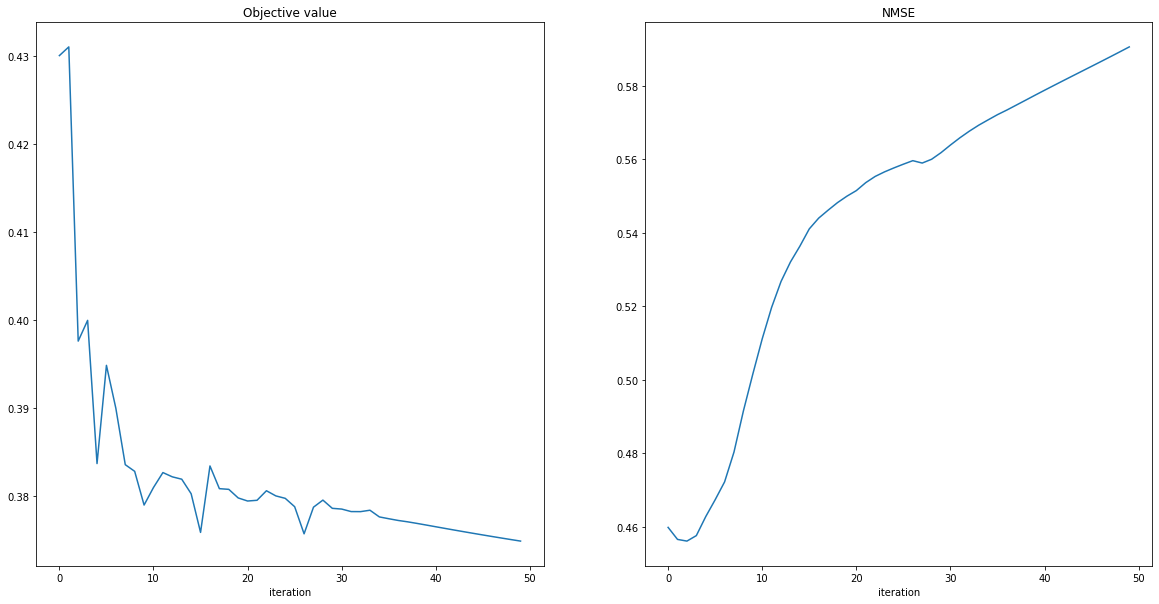

In [14]:
import matplotlib.pyplot as plt
a = 1
fig, axes = plt.subplots(1,2, figsize=(20, 10))
axes[0].plot(cost_list[a])
axes[0].set_title('Objective value')
axes[0].set_xlabel('iteration')
axes[1].plot(nmse_list[a])
axes[1].set_title('NMSE')
axes[1].set_xlabel('iteration')



In [49]:
fig.savefig('plt/onebit_lowrank2.pdf')

Text(0.5, 0, 'iteration')

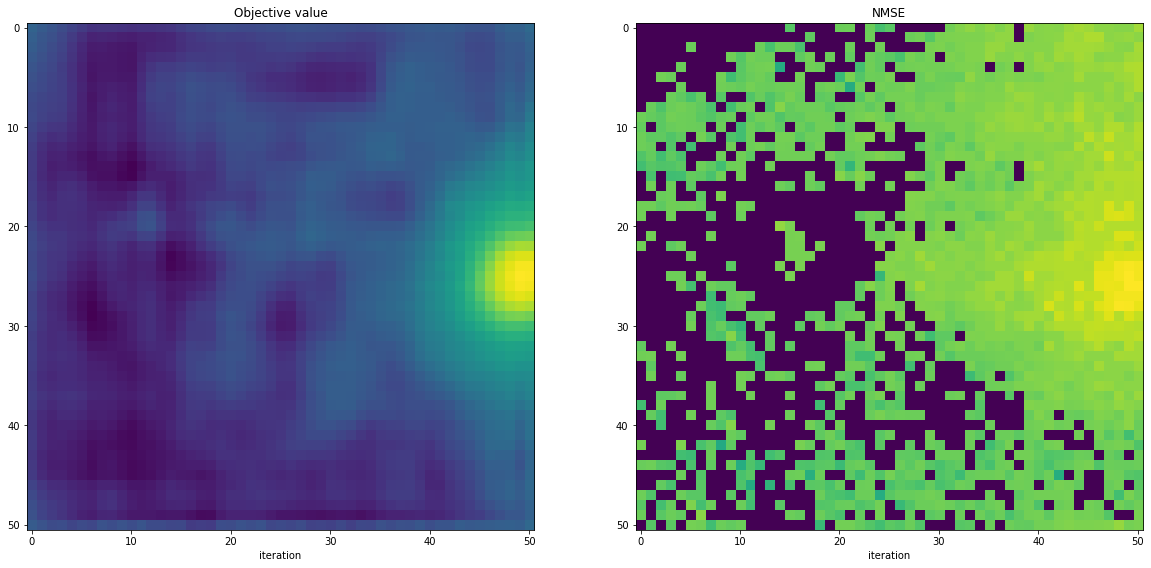

In [29]:
Sr = S.detach().clone()
Sr[Sr<0] = 0
fig, axes = plt.subplots(1,2, figsize=(20, 10))
axes[1].imshow(torch.log(Sr[0,0]+1e-12))
axes[0].set_title('Objective value')
axes[0].set_xlabel('iteration')
axes[0].imshow(torch.log(S_old[0]+1e-12))
axes[1].set_title('NMSE')
axes[1].set_xlabel('iteration')



Text(0.5, 1.0, 'After Optimization')

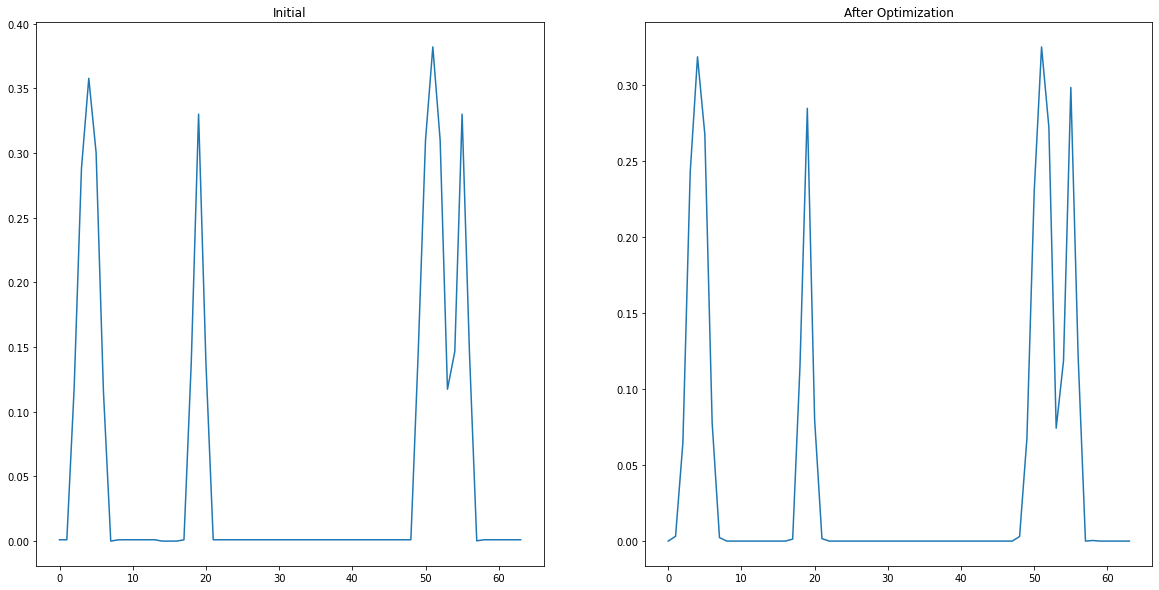

In [45]:
C_old = torch.from_numpy(data['C']).type(torch.float32)
fig, axes = plt.subplots(1,2, figsize=(20, 10))
axes[0].plot(C_old[:,0])
axes[0].set_title('Initial')
# axes[0].set_xlabel('iteration')
axes[1].plot(C[0,:].detach().numpy())
axes[1].set_title('After Optimization')
# axes[1].set_xlabel('iteration')

In [42]:
C

Parameter containing:
tensor([[-5.9708e-05,  3.1695e-03,  6.4604e-02,  2.4233e-01,  3.1847e-01,
          2.6752e-01,  7.7805e-02,  2.3186e-03, -3.4351e-04, -1.0265e-02,
         -5.9708e-05, -5.9708e-05, -5.9708e-05, -2.1766e-02, -8.0489e-03,
         -5.0170e-03, -1.1372e-02,  1.3049e-03,  1.1528e-01,  2.8461e-01,
          7.9713e-02,  1.6133e-03, -5.9708e-05, -5.9708e-05, -5.9708e-05,
         -5.9708e-05, -5.9708e-05, -5.9708e-05, -5.9708e-05, -5.9708e-05,
         -5.9708e-05, -5.9708e-05, -5.9708e-05, -5.9708e-05, -5.9708e-05,
         -5.9708e-05, -5.9708e-05, -5.9708e-05, -5.9708e-05, -5.9708e-05,
         -5.9708e-05, -5.9708e-05, -5.9708e-05, -5.9708e-05, -5.9708e-05,
         -5.9708e-05, -5.9708e-05, -5.9708e-05,  3.0214e-03,  6.7511e-02,
          2.3035e-01,  3.2499e-01,  2.7221e-01,  7.4257e-02,  1.1857e-01,
          2.9834e-01,  1.2134e-01, -1.3264e-03,  3.8205e-04, -5.9708e-05,
         -5.9708e-05, -5.9708e-05, -5.9708e-05, -5.9708e-05],
        [-1.3522e-04,  4.983

In [35]:
C[:,0]

tensor([1.0390e-03, 1.0390e-03, 1.1826e-01, 2.8801e-01, 3.5767e-01, 3.0015e-01,
        1.1583e-01, 3.3128e-18, 9.5786e-04, 1.0390e-03, 1.0390e-03, 1.0390e-03,
        1.0390e-03, 1.0356e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.6370e-04,
        1.3813e-01, 3.2995e-01, 1.3813e-01, 1.0390e-03, 1.0390e-03, 1.0390e-03,
        1.0390e-03, 1.0390e-03, 1.0390e-03, 1.0390e-03, 1.0390e-03, 1.0390e-03,
        1.0390e-03, 1.0390e-03, 1.0390e-03, 1.0390e-03, 1.0390e-03, 1.0390e-03,
        1.0390e-03, 1.0390e-03, 1.0390e-03, 1.0390e-03, 1.0390e-03, 1.0390e-03,
        1.0390e-03, 1.0390e-03, 1.0390e-03, 1.0390e-03, 1.0390e-03, 1.0390e-03,
        1.0390e-03, 1.4531e-01, 3.0987e-01, 3.8194e-01, 3.0987e-01, 1.1739e-01,
        1.4643e-01, 3.2995e-01, 1.4643e-01, 2.0166e-04, 1.0390e-03, 1.0390e-03,
        1.0390e-03, 1.0390e-03, 1.0390e-03, 1.0390e-03])

In [30]:
C.shape

torch.Size([2, 64])

In [23]:
S_old.shape

torch.Size([2, 51, 51])

In [19]:
Sr.shape

torch.Size([2, 1, 51, 51])

In [17]:
S[S<0] = 0

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

## Experiment in Log Format

In [1]:
import scipy.io as sio
from slf_dataset import mean_slf
import torch
import torch
import torch.nn as nn
from helper import *

mean = 0.0005
log_format = False
data = sio.loadmat('data/onebitdata')

mean_log = -8.2043

L = 10
f = 0.5
# std_probit = 0.008
std_probits = [0.00001, 0.0001, 0.001, 0.005, 0.008, 0.01, 0.02, 0.04]
# std_probits = [0.002, 0.003, 0.005, 0.006]

nmse_list = []

loss_model = 'probit'  # one of 'sigmoid', 'probit', and 'determ'

nmse = []
obj = []
for std_probit in std_probits:
    S = torch.from_numpy(data['S']).type(torch.float32)
    T = torch.from_numpy(data['T']).type(torch.float32)
    C = torch.from_numpy(data['C']).type(torch.float32)
    S_true = torch.from_numpy(data['S_true']).type(torch.float32)
    C_true = torch.from_numpy(data['C_true']).type(torch.float32)
    T_true = torch.from_numpy(data['T_true']).type(torch.float32)

    Om = torch.from_numpy(data['Om']).type(torch.float32)

    T = T.permute(2,0,1)
    T_true = T_true.permute(2,0,1)
    S = S.permute(2,0,1)
    S_true = S_true.permute(2,0,1)
    C = C.permute(1,0)
    C_true = C_true.permute(1,0)

    W = Om.unsqueeze(dim=0)
    W = W.unsqueeze(dim=0)
    Wx = W.repeat(64,1,1,1)

    T_old = T.clone()
    S_old = S.clone()


    R,I,J = S.shape
    maxIter = 100

    if loss_model=='sigmoid':
        if log_format:
            T = torch.log10(T_true+ 1e-12)
            T = T - mean_log
        else:
            T = T_true-mean
        T = dither_sigmoid(T)
    elif loss_model=='probit':
        if log_format:
            T = torch.log(T_true + 1e-12)
            T = T - mean_log
        else:
            T = T_true-mean
        T = dither_probit(T, std_probit)
    elif loss_model =='determ':
        pass


    S = nn.Parameter(S.unsqueeze(dim=1).clone())
    C = nn.Parameter(C.clone())
    T_hat = get_tensor(S,C)
    ## Init optimizer
    optimizerC = torch.optim.Adam([C], lr=1)
    optimizerS = torch.optim.Adam([S], lr=1)

    if log_format:
        criterion = NegLikelihood(mean=mean_log, std=std_probit, probit=True if loss_model=='probit' else False)
    else:
        criterion = NegLikelihood(mean=mean, std=std_probit, probit=True if loss_model=='probit' else False)

    # maxIter=0

    for i in range(maxIter):
        # C optimization
        optimizerC.zero_grad()
        optimizerS.zero_grad()

        T_hat = get_tensor(S,C)
        
        if log_format:
            cost = criterion(torch.log10(T_hat+1e-12), T)
        else:
            cost = criterion(T_hat, T)
        print("Cost: {} and NMSE: {}".format(cost.item(), NMSE(T_true, T_hat)))

        cost.backward()
        optimizerC.step()
        optimizerS.step()
        
        with torch.no_grad():
            u, s, v = torch.svd(S)
            s[:,:,L:] = 0
            S.copy_(torch.matmul(torch.matmul(u, torch.diag_embed(s)), v.transpose(-2,-1)))
            C[C<0] = 0
            S[S<0] = 0
    print()
    nmse.append(NMSE(T_true, T_hat))
    obj.append(cost)
        

Cost: 6.2141289710998535 and NMSE: 0.455515056848526
Cost: 44.84654235839844 and NMSE: 0.9993831515312195
Cost: 16.156646728515625 and NMSE: 0.9997771382331848
Cost: 16.42577362060547 and NMSE: 0.9998680353164673
Cost: 16.608997344970703 and NMSE: 0.9999065399169922
Cost: 16.696102142333984 and NMSE: 0.9999265074729919
Cost: 16.74295997619629 and NMSE: 0.999939501285553
Cost: 16.815046310424805 and NMSE: 0.999948263168335
Cost: 16.854095458984375 and NMSE: 0.9999544620513916
Cost: 16.920175552368164 and NMSE: 0.9999589323997498
Cost: 16.96222686767578 and NMSE: 0.9999619722366333
Cost: 17.046327590942383 and NMSE: 0.9999653100967407
Cost: 17.07155990600586 and NMSE: 0.999967098236084
Cost: 17.106401443481445 and NMSE: 0.9999686479568481
Cost: 17.189302444458008 and NMSE: 0.9999710917472839
Cost: 17.234357833862305 and NMSE: 0.9999715685844421
Cost: 17.28361701965332 and NMSE: 0.9999746084213257
Cost: 17.350297927856445 and NMSE: 0.9999744296073914
Cost: 17.39715576171875 and NMSE: 0.99

Cost: 27.33143424987793 and NMSE: 0.999975860118866
Cost: 27.309364318847656 and NMSE: 0.9999765157699585
Cost: 27.310457229614258 and NMSE: 0.9999760985374451
Cost: 27.272571563720703 and NMSE: 0.999976396560669
Cost: 25.794286727905273 and NMSE: 0.9999767541885376
Cost: 27.324827194213867 and NMSE: 0.9999754428863525
Cost: 27.328453063964844 and NMSE: 0.9999761581420898
Cost: 27.3326358795166 and NMSE: 0.9999761581420898
Cost: 27.333837509155273 and NMSE: 0.9999765157699585
Cost: 27.3548641204834 and NMSE: 0.9999767541885376
Cost: 27.341047286987305 and NMSE: 0.9999764561653137
Cost: 27.357267379760742 and NMSE: 0.999976634979248
Cost: 27.35846710205078 and NMSE: 0.9999760985374451
Cost: 27.359668731689453 and NMSE: 0.9999765157699585
Cost: 27.395713806152344 and NMSE: 0.9999762773513794
Cost: 27.42334747314453 and NMSE: 0.999976396560669
Cost: 27.40472412109375 and NMSE: 0.9999762773513794
Cost: 27.403522491455078 and NMSE: 0.9999766945838928
Cost: 27.38610076904297 and NMSE: 0.9999

Cost: 0.6946120858192444 and NMSE: inf
Cost: 1.3378363847732544 and NMSE: 1.0301681756973267
Cost: 0.88510662317276 and NMSE: 1.4524977207183838
Cost: 0.6953622698783875 and NMSE: 8.82524585723877
Cost: 0.6946120858192444 and NMSE: inf
Cost: 1.0196495056152344 and NMSE: 1.1618826389312744
Cost: 0.7391512989997864 and NMSE: 2.133465528488159
Cost: 1.1318329572677612 and NMSE: 1.1108407974243164
Cost: 0.6946120858192444 and NMSE: inf
Cost: 0.952240526676178 and NMSE: 1.3845078945159912
Cost: 0.6946120858192444 and NMSE: inf
Cost: 0.7150010466575623 and NMSE: 2.6886160373687744
Cost: 0.8050630688667297 and NMSE: 2.0723330974578857
Cost: 0.711920440196991 and NMSE: 3.179304361343384
Cost: 0.7113087177276611 and NMSE: 2.573646068572998
Cost: 0.6946120858192444 and NMSE: inf
Cost: 0.7018154859542847 and NMSE: 3.5462069511413574
Cost: 0.6946120858192444 and NMSE: inf
Cost: 0.6944732666015625 and NMSE: 33.113895416259766
Cost: 0.6945805549621582 and NMSE: 17.532835006713867
Cost: 0.69454693794

Cost: 0.6905562877655029 and NMSE: 2.360386610031128
Cost: 0.6892970204353333 and NMSE: 2.494702100753784
Cost: 0.6895753145217896 and NMSE: 2.2501778602600098
Cost: 0.695765495300293 and NMSE: 1.7528361082077026
Cost: 0.6886208057403564 and NMSE: 2.61883807182312
Cost: 0.6914207339286804 and NMSE: 1.9584861993789673
Cost: 0.6899399161338806 and NMSE: 2.2996490001678467
Cost: 0.6887169480323792 and NMSE: 2.237231731414795
Cost: 0.688344419002533 and NMSE: 2.364708185195923
Cost: 0.6886311173439026 and NMSE: 2.2737438678741455
Cost: 0.6914142370223999 and NMSE: 2.0686566829681396
Cost: 0.6882339119911194 and NMSE: 2.3847129344940186
Cost: 0.6880891919136047 and NMSE: 2.268101930618286
Cost: 0.6884769797325134 and NMSE: 2.2009780406951904
Cost: 0.6878475546836853 and NMSE: 2.1197001934051514
Cost: 0.6899998188018799 and NMSE: 1.944634199142456
Cost: 0.7033277750015259 and NMSE: 1.6029726266860962
Cost: 0.6873834729194641 and NMSE: 2.327967405319214
Cost: 0.6874557137489319 and NMSE: 2.06

Cost: 0.6922580003738403 and NMSE: 2.506088972091675
Cost: 0.69224613904953 and NMSE: 2.1628823280334473
Cost: 0.6922234296798706 and NMSE: 2.1036434173583984
Cost: 0.6921807527542114 and NMSE: 2.269686460494995
Cost: 0.6921471953392029 and NMSE: 2.531904935836792
Cost: 0.6920526623725891 and NMSE: 2.6305346488952637
Cost: 0.6919353008270264 and NMSE: 2.473099708557129
Cost: 0.691879391670227 and NMSE: 2.296335220336914
Cost: 0.6918639540672302 and NMSE: 2.2389018535614014
Cost: 0.6918343305587769 and NMSE: 2.257967472076416
Cost: 0.6917569637298584 and NMSE: 2.2536773681640625
Cost: 0.6916477084159851 and NMSE: 2.1723179817199707
Cost: 0.6915233135223389 and NMSE: 2.0721585750579834
Cost: 0.6913787722587585 and NMSE: 2.0335066318511963
Cost: 0.6912566423416138 and NMSE: 2.0349202156066895
Cost: 0.6911623477935791 and NMSE: 2.0104570388793945
Cost: 0.6910829544067383 and NMSE: 1.9249072074890137
Cost: 0.6910422444343567 and NMSE: 1.8173621892929077
Cost: 0.6909886002540588 and NMSE: 1.

In [86]:
T = torch.log10(T_true+ 1e-12)
T = T - mean_log
dither_probit(T, std_probit)


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [84]:
T = dither_probit(T, std_probit)


In [85]:
T

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [79]:
T = torch.log10(T_true+ 1e-12)


In [81]:
T - mean_log

tensor([[[-3.7957, -3.7957, -3.7957,  ..., -3.7957, -3.7957, -3.7957],
         [-3.7957, -3.7957, -3.7957,  ..., -3.7957, -3.7957, -3.7957],
         [-3.7957, -3.7957, -3.7957,  ..., -3.7957, -3.7957, -3.7957],
         ...,
         [-3.7957, -3.7957, -3.7957,  ..., -3.7957, -3.7957, -3.7957],
         [-3.7957, -3.7957, -3.7957,  ..., -3.7957, -3.7957, -3.7957],
         [-3.7957, -3.7957, -3.7957,  ..., -3.7957, -3.7957, -3.7957]],

        [[ 2.7984,  2.8357,  2.8449,  ...,  3.2808,  3.3765,  3.4924],
         [ 2.8300,  2.9276,  2.8025,  ...,  3.3015,  3.3691,  3.5092],
         [ 2.8039,  2.8828,  2.8637,  ...,  3.3512,  3.3833,  3.5125],
         ...,
         [ 3.1668,  3.0330,  3.0776,  ...,  3.0732,  3.0814,  3.1817],
         [ 3.0597,  3.0443,  3.0475,  ...,  3.1179,  3.1175,  3.1953],
         [ 2.9355,  2.9823,  3.1723,  ...,  3.2856,  3.2080,  3.1440]],

        [[ 3.8688,  3.9021,  3.9325,  ...,  4.6131,  4.7274,  4.8455],
         [ 3.8497,  3.9596,  3.8629,  ...,  4

In [69]:
t_log = torch.log10(T_true+1e-12)

In [72]:
t_log.min()

tensor(-12.)

In [70]:
t_log.mean()

tensor(-8.2043)

In [62]:
obj, nmse

([tensor(0.6476, grad_fn=<BinaryCrossEntropyBackward>),
  tensor(0.6619, grad_fn=<BinaryCrossEntropyBackward>),
  tensor(0.6720, grad_fn=<BinaryCrossEntropyBackward>),
  tensor(0.6748, grad_fn=<BinaryCrossEntropyBackward>)],
 [tensor(0.5311, grad_fn=<DivBackward0>),
  tensor(0.5205, grad_fn=<DivBackward0>),
  tensor(0.4645, grad_fn=<DivBackward0>),
  tensor(0.4748, grad_fn=<DivBackward0>)])

In [33]:
obj

[tensor(6.3951, grad_fn=<BinaryCrossEntropyBackward>),
 tensor(0.3684, grad_fn=<BinaryCrossEntropyBackward>),
 tensor(0.5776, grad_fn=<BinaryCrossEntropyBackward>),
 tensor(0.6609, grad_fn=<BinaryCrossEntropyBackward>),
 tensor(0.6664, grad_fn=<BinaryCrossEntropyBackward>),
 tensor(0.6676, grad_fn=<BinaryCrossEntropyBackward>),
 tensor(0.6716, grad_fn=<BinaryCrossEntropyBackward>),
 tensor(0.6741, grad_fn=<BinaryCrossEntropyBackward>)]

In [45]:
nmse

[tensor(174390.0312, grad_fn=<DivBackward0>),
 tensor(74.3055, grad_fn=<DivBackward0>),
 tensor(50.2608, grad_fn=<DivBackward0>),
 tensor(10.8408, grad_fn=<DivBackward0>),
 tensor(8.4904, grad_fn=<DivBackward0>),
 tensor(7.6658, grad_fn=<DivBackward0>),
 tensor(6.4309, grad_fn=<DivBackward0>),
 tensor(5.7763, grad_fn=<DivBackward0>)]

In [36]:
obj, nmse

([tensor(0.5130, grad_fn=<BinaryCrossEntropyBackward>),
  tensor(0.3245, grad_fn=<BinaryCrossEntropyBackward>),
  tensor(0.0076, grad_fn=<BinaryCrossEntropyBackward>),
  tensor(0.4771, grad_fn=<BinaryCrossEntropyBackward>),
  tensor(0.5839, grad_fn=<BinaryCrossEntropyBackward>),
  tensor(0.6173, grad_fn=<BinaryCrossEntropyBackward>),
  tensor(0.6595, grad_fn=<BinaryCrossEntropyBackward>),
  tensor(0.6705, grad_fn=<BinaryCrossEntropyBackward>)],
 [tensor(0.4515, grad_fn=<DivBackward0>),
  tensor(0.5395, grad_fn=<DivBackward0>),
  tensor(0.6116, grad_fn=<DivBackward0>),
  tensor(0.5606, grad_fn=<DivBackward0>),
  tensor(0.6545, grad_fn=<DivBackward0>),
  tensor(0.6995, grad_fn=<DivBackward0>),
  tensor(0.8411, grad_fn=<DivBackward0>),
  tensor(0.9388, grad_fn=<DivBackward0>)])

Parameter containing:
tensor([[[[-4.6622e-04,  2.0686e-04,  1.8271e-03,  ..., -1.2461e-04,
           -2.1222e-03, -5.9601e-04],
          [ 1.2514e-05,  9.0642e-04, -8.7370e-04,  ...,  6.1108e-04,
            1.0805e-03,  1.9294e-04],
          [-9.3994e-04,  1.0407e-03, -1.2898e-03,  ...,  4.0016e-04,
            1.7589e-04, -2.0034e-03],
          ...,
          [-1.6798e-03, -4.3598e-06, -1.2611e-03,  ...,  5.3225e-04,
           -5.2759e-04,  3.2719e-04],
          [ 1.1286e-03,  1.6929e-03, -2.1576e-04,  ...,  8.4778e-04,
            1.8924e-03,  5.0794e-05],
          [-1.3517e-03, -2.0486e-03,  1.1245e-03,  ..., -4.7599e-04,
           -1.2820e-03, -1.1674e-03]]],


        [[[ 6.3163e-04, -5.5580e-04,  1.2040e-03,  ...,  1.5715e-04,
            1.0646e-03,  6.8892e-04],
          [ 7.7284e-04, -1.3954e-04, -2.0132e-03,  ..., -1.2535e-03,
           -1.2566e-04, -1.3598e-03],
          [-1.2012e-03,  1.5482e-03,  1.0200e-04,  ...,  1.0633e-04,
           -2.1912e-03, -4.8944e-0

In [6]:
S

Parameter containing:
tensor([[[[-3.8271e-04,  1.6921e-03, -5.2727e-04,  ..., -1.8864e-03,
           -6.2064e-04,  3.2606e-03],
          [-2.4001e-04,  2.3075e-04, -8.1671e-04,  ..., -1.0369e-03,
            6.1514e-05,  3.4414e-03],
          [ 8.0077e-04, -3.5585e-04, -9.3176e-04,  ..., -3.3947e-04,
           -3.0626e-03,  7.9395e-04],
          ...,
          [-1.0912e-03, -9.0871e-04,  3.4139e-04,  ..., -1.5516e-03,
           -1.2543e-04, -8.9093e-04],
          [ 1.5234e-03,  3.8471e-05,  1.0692e-03,  ...,  1.1878e-04,
            3.2860e-04,  6.5033e-04],
          [ 2.8007e-04,  1.3684e-04, -6.1396e-04,  ...,  6.0659e-04,
           -1.0371e-03, -2.7305e-03]]],


        [[[ 3.1062e-03,  1.2885e-03,  3.7598e-03,  ..., -2.4098e-03,
            8.6266e-04, -2.6907e-03],
          [ 2.2329e-03,  2.9166e-03,  1.9997e-03,  ..., -2.0184e-03,
            4.5686e-03, -1.0366e-03],
          [-1.3312e-03, -1.3846e-03,  1.7694e-03,  ...,  1.2846e-03,
           -2.2935e-03,  9.0887e-0

In [251]:
T_true.shape

torch.Size([64, 51, 51])

In [252]:
T.shape

torch.Size([64, 51, 51])

In [184]:
Sc = S.clone()

with torch.no_grad():
    u, s, v = torch.svd(S)
    S = torch.matmul(torch.matmul(u, torch.diag_embed(s)), v.transpose(-2,-1)) 
Y = S*2
    
loss = torch.norm(Y)
loss.backward()
print(S.grad)

u, s, v = torch.svd(Sc)
Sc = torch.matmul(torch.matmul(u, torch.diag_embed(s)), v.transpose(-2,-1)) 
loss = torch.norm(Sc)
loss.backward()
print(Sc.grad)

    

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [59]:
u, s, v = torch.svd(S)
s[:,:,:] = 0
Sf = torch.matmul(torch.matmul(u, torch.diag_embed(s)), v.transpose(-2,-1)) 
torch.dist(Sf, S)

tensor(1.1634, grad_fn=<DistBackward>)

In [185]:
make_dot

NameError: name 'make_dot' is not defined

In [181]:
Sc.requires_grad

True

In [225]:
a = nn.Parameter(torch.ones(5))

optim = torch.optim.SGD([a], lr=0.01)

b = 2*a*a

loss = b.sum()
loss.backward()
optim.step()
print(a)
print(a.grad)
with torch.no_grad():
    a.copy_(torch.ones(5))
  
c = 2*a*a

loss = c.sum()
optim.zero_grad()
  
loss.backward()

optim.step()
print(a)

Parameter containing:
tensor([0.9600, 0.9600, 0.9600, 0.9600, 0.9600], requires_grad=True)
tensor([4., 4., 4., 4., 4.])
Parameter containing:
tensor([0.9600, 0.9600, 0.9600, 0.9600, 0.9600], requires_grad=True)


In [214]:
a

Parameter containing:
tensor([0.9216, 0.9216, 0.9216, 0.9216, 0.9600], requires_grad=True)

In [193]:
a

Parameter containing:
tensor([0.9800, 0.9800, 0.9800, 0.9800, 0.9800], requires_grad=True)

In [186]:
torch.ones(5)

tensor([1., 1., 1., 1., 1.])